In [1]:
from big_helper import *
from skimage.color import rgb2gray
from math import prod
from tqdm import tqdm

name = 'baby'
num = 36
size = (28,28)
N = prod(size)
make_bw = True

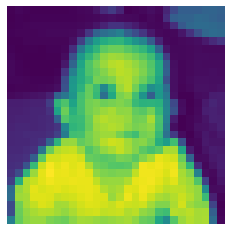

In [2]:
imgs = get_images(name, num, size) 
if name == 'TEXCOL':
    imgs = [img[0] for img in imgs] # 0 img, 1 colour mask, 2 texture mask


if make_bw == True:
    imgs = [rgb2gray(img) for img in imgs]

plt.rcParams["figure.figsize"] = (5,5)
plot_images(imgs)

100%|██████████| 2/2 [00:02<00:00,  1.37s/it]


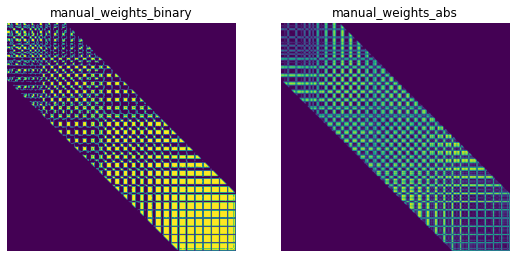

In [3]:
radius = N // 4
sigmaI = 0.1
sigmaX = 0.5

choice = 1
choices = ["manual_weights_binary", "manual_weights_abs", "intensity_weight_matrix", "weights_2", 
           "positional_weight_matrix", "intens_posit_wm", "weight_tot", "weight_int", "weight_dist",
           "generic_weight+texture", "generic_weight+colour", "generic_weight_noexp+texture", "generic_weight_noexp+colour",
           "generic_weight_rawfunc+texture", "generic_weight_rawfunc+colour", "manual_weights_abs_upper",
           "weight_int_broken", "weight_int_broken2"]

# choice_of_choices = [0,1,2,4,5]
# choice_of_choices = [0,1,2,4,5,7,15]
# choice_of_choices =[0,1,2,5,7,16,17]
choice_of_choices = [0,1]

singleImage = True

# TODO: fix weight int and the new ones :)

if singleImage:
    weight_labels = []
    weights = []
    for i in tqdm(choice_of_choices):
        weights.append(get_weights(imgs[0], i, radius, sigmaI, sigmaX))
        weight_labels.append(choices[i])
else:
    weight_labels = None
    weights = [get_weights(img, choice, radius, sigmaI, sigmaX) for img in imgs]
    
plt.rcParams["figure.figsize"] = (9,9) # specify the size for this cell
plot_images(weights, weight_labels)

# TODO: make a weights matrix which is just each individual pixel refering to itself :)
# identity matrix?

# from numpy.linalg import matrix_rank
# print(matrix_rank(weights[0].T))

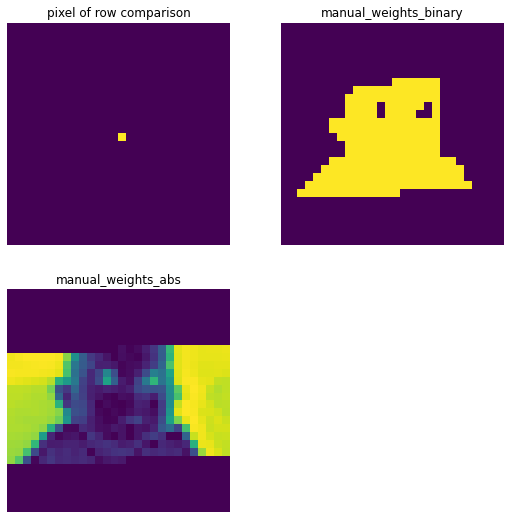

In [4]:
# plot a weight row as an image... should highlight the similar pixels
plot_1 = True
plot_2 = plot_3 = False

if plot_1:
    row = N // 2 + 28//2

    blank = np.zeros_like(imgs[0])
    x,y = row // size[0], row % size[1]
    blank[x,y] = 255
    weight_labels.insert(0, "pixel of row comparison")
    images = [blank]
    
    for weight in weights:
        images.append(weight[row].reshape(size))
        
    plot_images(images, weight_labels) 

if plot_2:
    row = N // 4
    
    blank = np.zeros_like(imgs[0])
    x,y = row // size[0], row % size[1]
    blank[x,y] = 255
    images = [blank]
    
    for weight in weights:
        images.append(weight[row].reshape(size))

    plt.rcParams["figure.figsize"] = (9,9) # specify the size for this cell
    plot_images(images, labels) 

if plot_3:
    row = round(0.9 * N)
    
    blank = np.zeros_like(imgs[0])
    x,y = row // size[0], row % size[1]
    blank[x,y] = 255
    images = [blank]
    
    for weight in weights:
        images.append(weight[row].reshape(size))

    plt.rcParams["figure.figsize"] = (9,9) # specify the size for this cell
    plot_images(images, labels) 

In [5]:
example = [norm_weights, ]

In [6]:
# quick and dirty solve test

# TODO: add sparse linalg ones
standard, generalized = get_eigensolvers()
laplacians = get_laplacians()

vals = []
vals_spectrum = []
vecs = []
vecs_flat = []
labels = []


std = True
gen = False
lobpcg = False

# np.random.seed(0)
for W, label in zip(weights, weight_labels[1:]):
    # W = W/np.max(W)
    for laplace_name, laplace_func in laplacians.items():
        for name, func in (pbar := tqdm(standard.items())):
            pbar.set_description(f'{label} - {laplace_name}')
            if std:
                try:
                    val, vec = func(laplace_func(W))
                    
                    index = argmin2(val)
                    
                    vecs_flat.append(vec[index])
                    vecs.append(np.real(vec[index].reshape(size)))
                    vals.append(np.real(val[index]))
                    vals_spectrum.append(np.real(val))
                    labels.append(name)
                    # print(f'{name} : val[{index}]={vals[-1]}')
                except Exception as err:
                    print(f'{name } : {err}')
                    continue
        
            if gen:
                d = np.sum(W,0)
                D = np.diag(d)
                try:
                    val, vec = func((D-W), D)
                    
                    index = argmin2(val)
                    
                    vecs_flat.append(vec[index])
                    vecs.append(np.real(vec[index].reshape(size)))
                    vals.append(np.real(val[index]))
                    vals_spectrum.append(np.real(val))
                    labels.append(name)
                    print(f'{name} : val[{index}]={vals[-1]}')
                except Exception as err:
                    print(f'{name } : {err}')
                    continue
            
        if lobpcg:
            # also do lobpcg by hand since it needs an approximation vector X also included
            # can do generalized and standard forms.
            # lobpcg(A,X,B) or lobpcg(A,X), depending on the inputs feed to it :)
            import scipy.sparse.linalg as sparse
            X_2 = np.random.uniform(size=(N, 2))
            X_10 = np.random.uniform(size=(N, 10))

            A = D-W
            B = D
            
            if gen:
                name = "sparse A,X_2,B"
                w_1,v_1 = sparse.lobpcg(A, X_2, B, largest=False)
                index = argmin2(w_1)
                vecs.append(np.real(v_1[index].reshape(size)))
                labels.append(name)
                print(f'{name} : val[{index}]={vals[-1]}')
                
                name = "sparse A,X_10,B"
                w_2, v_2 = sparse.lobpcg(A, X_10, B, largest=False)
                index = argmin2(w_2)
                vecs.append(np.real(v_2[index].reshape(size)))
                labels.append(name)
            # if std:
                # TODO: make this match above
                # w_1, v_1 = sparse.lobpcg(A, X_2, largest=False)
                # index = argmin2(w_1)
                # vecs.append(np.real(v_1[index].reshape(size)))
                # labels.append(f'sparse A,X_2 [{index}]')
                # w_2, v_2 = sparse.lobpcg(A, X_10, largest=False)
                # index = argmin2(w_2)
                # vecs.append(np.real(v_2[index].reshape(size)))
                # labels.append(f'sparse A,X_10 [{index}]')

manual_weights_binary - non_symm: 100%|██████████| 10/10 [00:02<00:00,  3.64it/s]


eigh_evx_inf5 : cannot reshape array of size 8 into shape (28,28)
eigh_evx_inf10 : cannot reshape array of size 14 into shape (28,28)


manual_weights_binary - laplace_expensive:   0%|          | 0/10 [00:00<?, ?it/s]/mnt/c/Users/garth/Desktop/DDN/big_helper.py:320: RuntimeWarning: divide by zero encountered in true_divide
  sqrt_D_inv = np.diag(1.0 / np.sqrt(D)) # assumes D is 1 dimensional vector
/mnt/c/Users/garth/Desktop/DDN/big_helper.py:322: RuntimeWarning: invalid value encountered in matmul
  return sqrt_D_inv @ (D - W) @ sqrt_D_inv
manual_weights_binary - laplace_expensive:   0%|          | 0/10 [00:00<?, ?it/s]

np_eig : Array must not contain infs or NaNs


manual_weights_binary - laplace_expensive:  40%|████      | 4/10 [00:00<00:00, 10.18it/s]

eig : array must not contain infs or NaNs


manual_weights_binary - laplace_expensive:  50%|█████     | 5/10 [00:21<00:31,  6.37s/it]

eigh_ev : The algorithm failed to converge; 783 off-diagonal elements of an intermediate tridiagonal form did not converge to zero.


manual_weights_binary - laplace_expensive: 100%|██████████| 10/10 [00:43<00:00,  4.38s/it]


eigh_evx_inf5 : cannot reshape array of size 0 into shape (28,28)
eigh_evx_inf10 : cannot reshape array of size 0 into shape (28,28)


manual_weights_binary - laplace_cheap:   0%|          | 0/10 [00:00<?, ?it/s]

np_eig : matmul: Input operand 1 does not have enough dimensions (has 0, gufunc core with signature (n?,k),(k,m?)->(n?,m?) requires 1)
np_eigh_upper : matmul: Input operand 1 does not have enough dimensions (has 0, gufunc core with signature (n?,k),(k,m?)->(n?,m?) requires 1)
eig : matmul: Input operand 1 does not have enough dimensions (has 0, gufunc core with signature (n?,k),(k,m?)->(n?,m?) requires 1)
eigh : matmul: Input operand 1 does not have enough dimensions (has 0, gufunc core with signature (n?,k),(k,m?)->(n?,m?) requires 1)
eigh_ev : matmul: Input operand 1 does not have enough dimensions (has 0, gufunc core with signature (n?,k),(k,m?)->(n?,m?) requires 1)
eigh_evd : matmul: Input operand 1 does not have enough dimensions (has 0, gufunc core with signature (n?,k),(k,m?)->(n?,m?) requires 1)
eigh_evr : matmul: Input operand 1 does not have enough dimensions (has 0, gufunc core with signature (n?,k),(k,m?)->(n?,m?) requires 1)


manual_weights_binary - laplace_cheap: 100%|██████████| 10/10 [00:00<00:00, 258.29it/s]


eigh_evx : matmul: Input operand 1 does not have enough dimensions (has 0, gufunc core with signature (n?,k),(k,m?)->(n?,m?) requires 1)
eigh_evx_inf5 : matmul: Input operand 1 does not have enough dimensions (has 0, gufunc core with signature (n?,k),(k,m?)->(n?,m?) requires 1)
eigh_evx_inf10 : matmul: Input operand 1 does not have enough dimensions (has 0, gufunc core with signature (n?,k),(k,m?)->(n?,m?) requires 1)


manual_weights_abs - non_symm: 100%|██████████| 10/10 [00:02<00:00,  3.45it/s]


eigh_evx_inf5 : cannot reshape array of size 1 into shape (28,28)
eigh_evx_inf10 : cannot reshape array of size 1 into shape (28,28)


manual_weights_abs - laplace_cheap: 100%|██████████| 10/10 [00:00<00:00, 228.03it/s]

np_eig : matmul: Input operand 1 does not have enough dimensions (has 0, gufunc core with signature (n?,k),(k,m?)->(n?,m?) requires 1)
np_eigh_upper : matmul: Input operand 1 does not have enough dimensions (has 0, gufunc core with signature (n?,k),(k,m?)->(n?,m?) requires 1)
eig : matmul: Input operand 1 does not have enough dimensions (has 0, gufunc core with signature (n?,k),(k,m?)->(n?,m?) requires 1)
eigh : matmul: Input operand 1 does not have enough dimensions (has 0, gufunc core with signature (n?,k),(k,m?)->(n?,m?) requires 1)
eigh_ev : matmul: Input operand 1 does not have enough dimensions (has 0, gufunc core with signature (n?,k),(k,m?)->(n?,m?) requires 1)
eigh_evd : matmul: Input operand 1 does not have enough dimensions (has 0, gufunc core with signature (n?,k),(k,m?)->(n?,m?) requires 1)
eigh_evr : matmul: Input operand 1 does not have enough dimensions (has 0, gufunc core with signature (n?,k),(k,m?)->(n?,m?) requires 1)
eigh_evx : matmul: Input operand 1 does not have

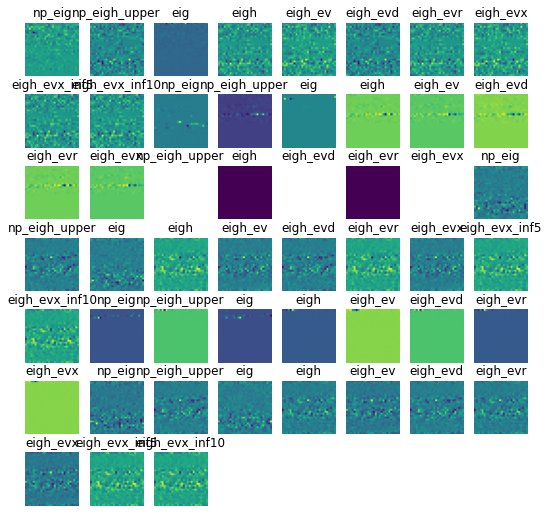

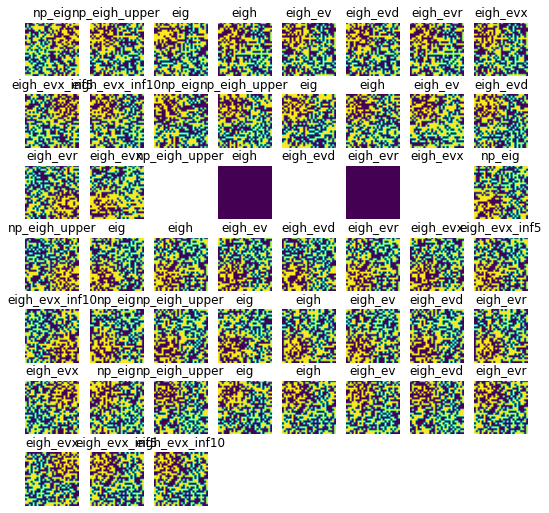

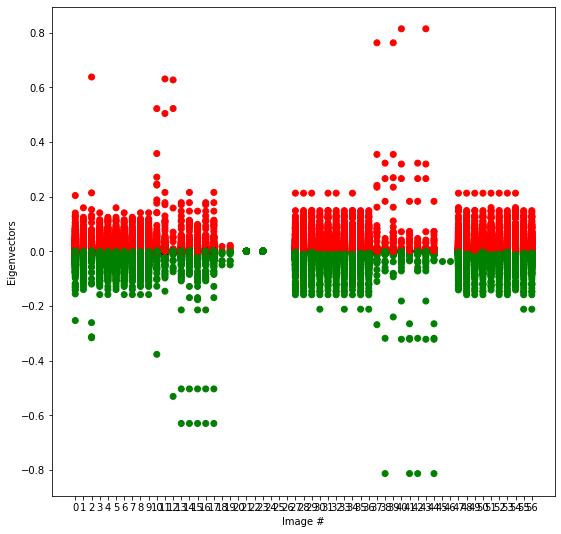

In [7]:
plot_images(vecs, labels)
plot_images(np.sign(vecs), labels)


# plot_range(vals_spectrum, 'Eigenvalues')
plot_range(vecs_flat, 'Eigenvector spectrum')

In [8]:
# different valid image sets
# (real images too?)

# different weighting functions
# intens, position, affinity, intens * position...

# plot specific rows of the weights matrix (e.g. for intensity should show similar things in image)

# different weightings with W/np.max(W) (e.g. do we normalize the weights before doing laplace?)

# different laplace solvers
# cheap, expensive, symmetric/none...
# how to handle 0's in D? or... how to handle 0's in d?

# different eigensolvers
# initially try for just one eig solver?
# Time the eigensolvers

# linalg.eig(L)
# np.eig(L)

# linalg.eigh(L)
# linalg.eig(L)
# linalg.eigh(L,D)
# linalg.eig(L,D)
# plus the gvd variants etc....

# lobpcg (specifically setup for finding small eigenvalues unlike most other methods :) )

# outputs
# and with... * 28, * eigval, * np.sqrt(D)
# sign of outputs to make it an indicator vector
# objective, eqconst

# plot the eigenvalues for a different method... (see if > 0)
# plot the eigenvectors for different inputs
# plot ncut cost, at different partitions of the eigenvector range
# ^ and do this for the first so many eigenvectors :)

# also other plots probably mentioned in eigs-test2 or nc-test2/nc-test3... etc